<a href="https://colab.research.google.com/github/zgrigoryan/regression_problem/blob/main/Regression_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



This challenge explores the full machine learning pipeline for a regression problem.
The work is done on a real-world dataset, data cleaning and transformation is performed,
and two regression algorithms are implemented:
KNN and Linear Regression.
In addition, scikit-learn’s implementations are used to benchmark the work.



Import **Taxi Price Regression 🚕** dataset

In [6]:
import kagglehub

# Authenticate
kagglehub.login()

# Download latest version
path = kagglehub.dataset_download("denkuznetz/taxi-price-prediction")

print("Path to dataset files:", path)

ModuleNotFoundError: No module named 'kagglehub'

In [7]:
import pandas as pd
import os

data_path = "/kaggle/input/taxi-price-prediction"
print(os.listdir(data_path))  # shwos what files you can see

df = pd.read_csv(os.path.join(data_path, "taxi_trip_pricing.csv"))

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/taxi-price-prediction'

After importing dataset from kaggle, the next step is conducting exploratory data analysis (EDA)  

In [ ]:
# ──────────────────────────────────────────────────────────
# 1. Imports & settings
# ──────────────────────────────────────────────────────────
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")  # nice default look
plt.rcParams["figure.figsize"] = (10, 6)   # larger charts

**First glance**

In [ ]:
display(df.head())
print("\nShape:", df.shape)
df.info(show_counts=True)             # dtypes + non-null counts
df.describe().T      # stats for numeric cols

,Trip_Distance_km,Time_of_Day,Day_of_Week,Passenger_Count,Traffic_Conditions,Weather,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price
0,19.35,Morning,Weekday,3.0,Low,Clear,3.56,0.80,0.32,53.82,36.2624
1,47.59,Afternoon,Weekday,1.0,High,Clear,NaN,0.62,0.43,40.57,NaN
2,36.87,Evening,Weekend,1.0,High,Clear,2.70,1.21,0.15,37.27,52.9032
3,30.33,Evening,Weekday,4.0,Low,NaN,3.48,0.51,0.15,116.81,36.4698
4,NaN,Evening,Weekday,3.0,High,Clear,2.93,0.63,0.32,22.64,15.6180



Shape: (1000, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Trip_Distance_km       950 non-null    float64
 1   Time_of_Day            950 non-null    object 
 2   Day_of_Week            950 non-null    object 
 3   Passenger_Count        950 non-null    float64
 4   Traffic_Conditions     950 non-null    object 
 5   Weather                950 non-null    object 
 6   Base_Fare              950 non-null    float64
 7   Per_Km_Rate            950 non-null    float64
 8   Per_Minute_Rate        950 non-null    float64
 9   Trip_Duration_Minutes  950 non-null    float64
 10  Trip_Price             951 non-null    float64
dtypes: float64(7), object(4)
memory usage: 86.1+ KB


,count,mean,std,min,25%,50%,75%,max
Trip_Distance_km,950.0,27.070547,19.905300,1.2300,12.63250,25.8300,38.40500,146.067047
Passenger_Count,950.0,2.476842,1.102249,1.0000,1.25000,2.0000,3.00000,4.000000
Base_Fare,950.0,3.502989,0.870162,2.0100,2.73000,3.5200,4.26000,5.000000
Per_Km_Rate,950.0,1.233316,0.429816,0.5000,0.86000,1.2200,1.61000,2.000000
Per_Minute_Rate,950.0,0.292916,0.115592,0.1000,0.19000,0.2900,0.39000,0.500000
Trip_Duration_Minutes,950.0,62.118116,32.154406,5.0100,35.88250,61.8600,89.05500,119.840000
Trip_Price,951.0,56.874773,40.469791,6.1269,33.74265,50.0745,69.09935,332.043689


**Data Quality checks**

Duplicate rows: 0


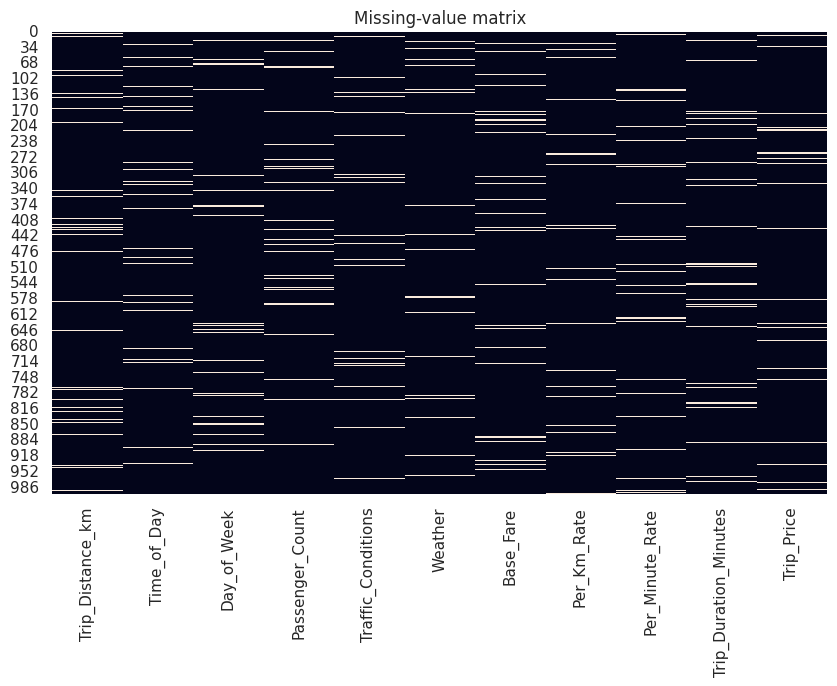

In [ ]:
# missing values heat-map
sns.heatmap(df.isna(), cbar=False)
plt.title("Missing-value matrix")

# duplicates
dupes = df.duplicated().sum()
print(f"Duplicate rows: {dupes}")

Target (Fare) Distribution

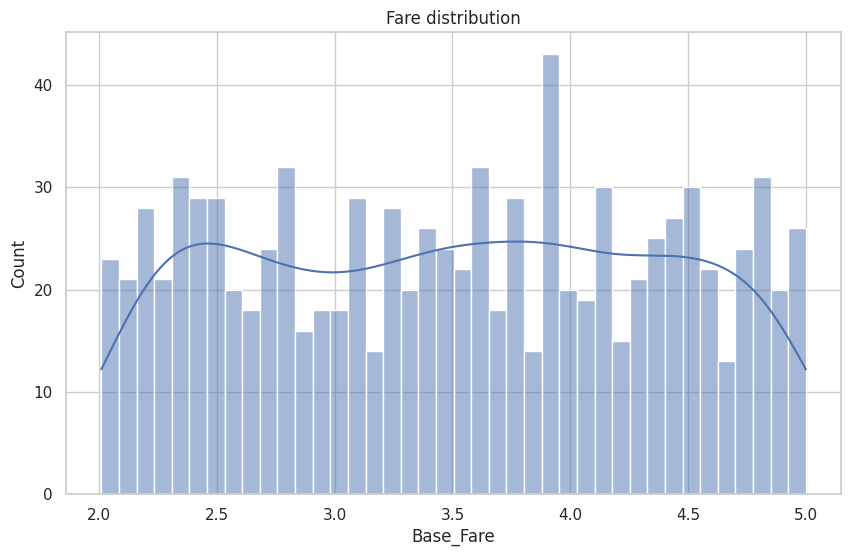

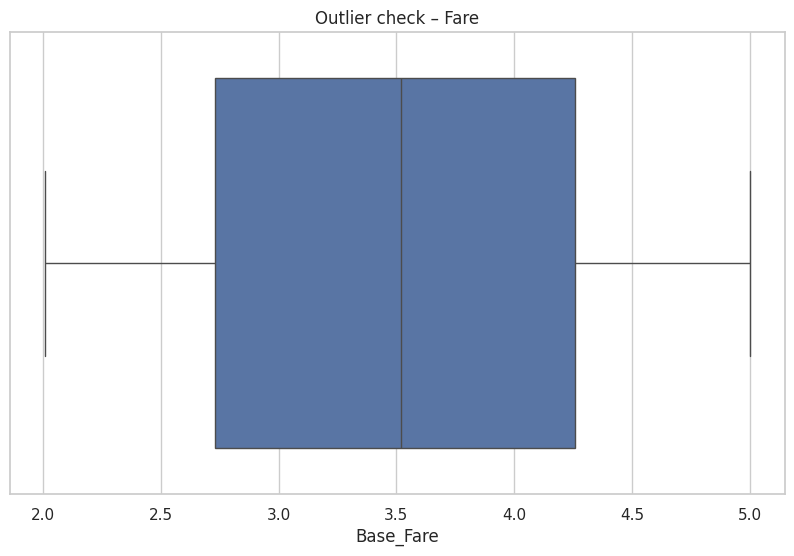

In [ ]:
sns.histplot(df["Base_Fare"], bins=40, kde=True)
plt.title("Fare distribution")
plt.show()

sns.boxplot(x=df["Base_Fare"])
plt.title("Outlier check – Fare")
plt.show()

**Numerical feature exploration**

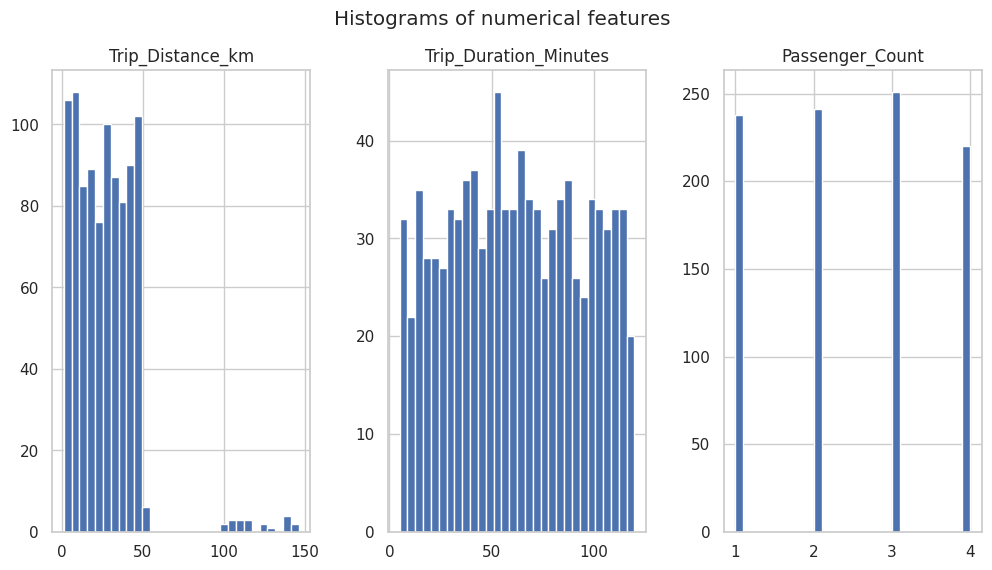

In [ ]:
num_cols = ["Trip_Distance_km", "Trip_Duration_Minutes", "Passenger_Count"]

df[num_cols].hist(bins=30, figsize=(12, 6), layout=(1, len(num_cols)))
plt.suptitle("Histograms of numerical features")
plt.show()

  *Correlations*

Text(0.5, 1.0, 'Correlation heat-map')

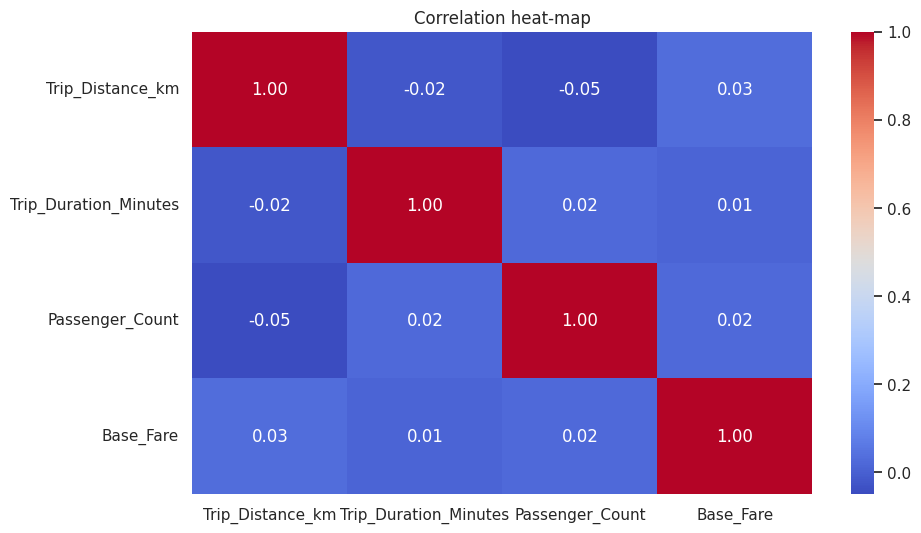

In [26]:
corr = df[num_cols + ["Base_Fare"]].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation heat-map")

*Feature ↔︎ Fare relationships*

([0, 1, 2, 3],
 [Text(0, 0, 'Morning'),
  Text(1, 0, 'Afternoon'),
  Text(2, 0, 'Evening'),
  Text(3, 0, 'Night')])

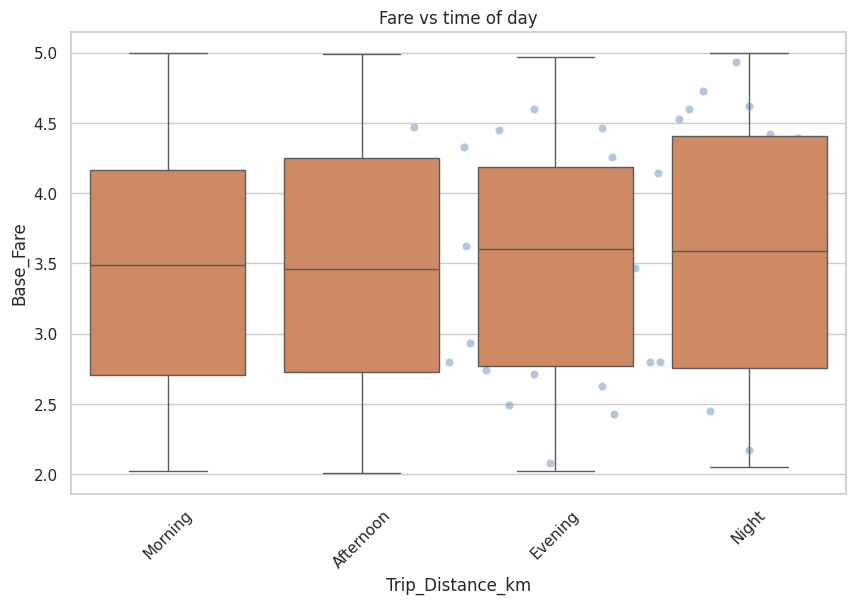

In [27]:
# distance vs fare
sns.scatterplot(x="Trip_Distance_km", y="Base_Fare", data=df, alpha=.4)
plt.title("Fare vs distance")

sns.boxplot(x="Time_of_Day", y="Base_Fare", data=df)
plt.title("Fare vs time of day")
plt.xticks(rotation=45)

*Categorical Features*

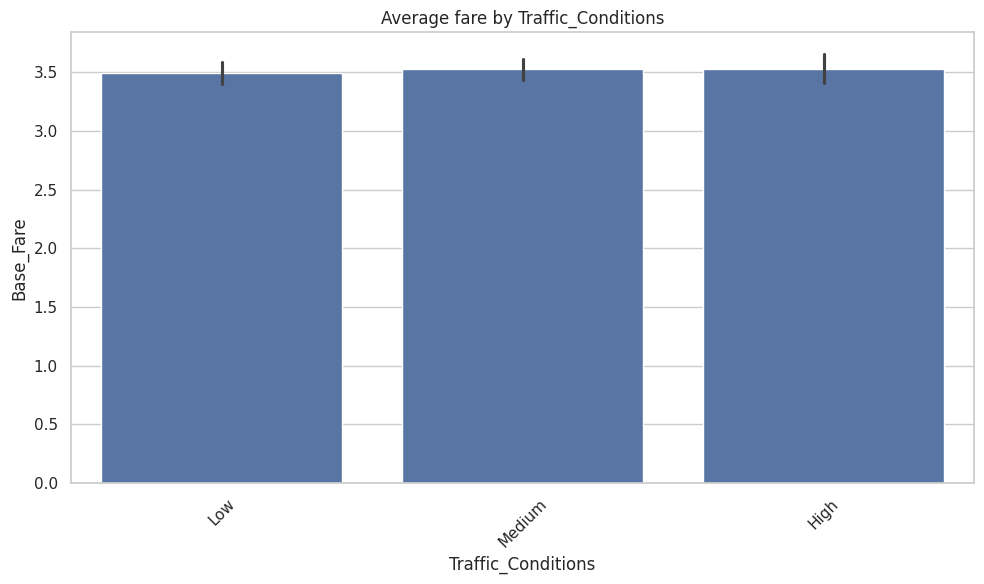

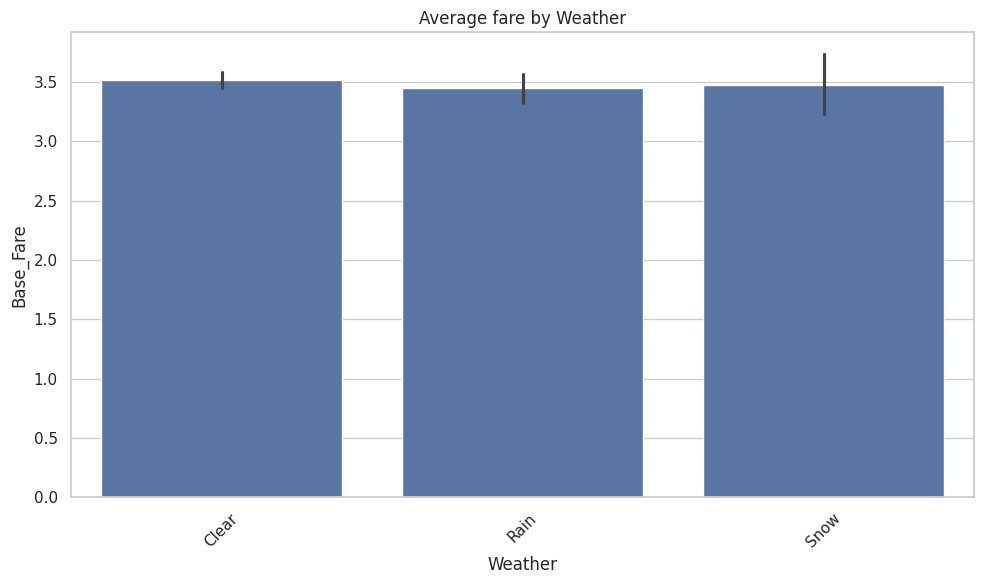

In [28]:
cat_cols = ["Traffic_Conditions", "Weather"]

for col in cat_cols:
    plt.figure()
    order = df[col].value_counts().index
    sns.barplot(x=col, y="Base_Fare", data=df, estimator=np.mean, order=order)
    plt.title(f"Average fare by {col}")
    plt.xticks(rotation=45)
    plt.tight_layout()

*Outlier and leverage points*

In [29]:
from scipy import stats

z = np.abs(stats.zscore(df[num_cols], nan_policy="omit"))
outliers = (z > 3).any(axis=1)
print("Potential high-leverage rows:", outliers.sum())

Potential high-leverage rows: 20


In [5]:
# Summary of EDA
print("EDA Summary:")
print("-" * 50)

# Data Quality
print("1. Data Quality:")
print(f"   - Missing values: {df.isna().sum().sum()} (visualized in heatmap)")
print(f"   - Duplicate rows: {dupes}")

# Target Distribution
print("\n2. Target (Fare) Distribution:")
print("   - Distribution visualized using histogram and boxplot.")
print("   - Check for outliers in the 'Base_Fare' column.")

# Numerical Features
print("\n3. Numerical Features:")
print("   - Histograms plotted for numerical columns: Trip_Distance_km, Trip_Duration_Minutes, Passenger_Count.")
print("   - Correlation heatmap shows relationships between numerical features and Base_Fare.")

# Feature ↔︎ Fare Relationships
print("\n4. Feature ↔︎ Fare Relationships:")
print("   - Scatterplot: Fare vs Trip_Distance_km.")
print("   - Boxplot: Fare vs Time_of_Day.")

# Categorical Features
print("\n5. Categorical Features:")
print("   - Barplots show average fare by Traffic_Conditions and Weather.")

# Outliers and Leverage Points
print("\n6. Outliers and Leverage Points:")
print(f"   - Potential high-leverage rows detected: {outliers.sum()} (based on z-score > 3).")

EDA Summary:
--------------------------------------------------
1. Data Quality:


NameError: name 'df' is not defined